In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the linear transformation $X W + b$ and then the softmax function to obtain the class probabilities predicted by the model.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Add 5 new layers
        H1 = 200
        H2 = 100
        H3 = 60
        H4 = 30
        #U = 200

        U1 = 4
        self.W1 = nn.Parameter(0.1 * torch.randn(U1, 1, 5, 5))
        self.b1 = nn.Parameter(torch.ones(U1)/10)

        U2 = 8
        self.W2 = nn.Parameter(0.1 * torch.randn(U2, 1, 5, 5))
        self.b1 = nn.Parameter(torch.ones(U2)/10)


        U3 = 12
        self.W3 = nn.Parameter(0.1 * torch.randn(U3, 1, 4, 4))
        self.b1 = nn.Parameter(torch.ones(U3)/10)


        self.W4 = nn.Parameter(0.1 * torch.randn(H3, H4))
        self.b4 = nn.Parameter(torch.ones(H4)/(H4))

        self.W5 = nn.Parameter(0.1 * torch.randn(H4, 10))
        self.b5 = nn.Parameter(torch.ones(10)/10)

        # self.W6 = nn.Parameter(0.1 * torch.randn(U, 10))
        # self.b6 = nn.Parameter(torch.ones(10)/10)

    def forward(self, X):
        # # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # # compute the linear transformation
        # Q = torch.sigmoid(X.mm(self.W1) + self.b1)
        # # Z = X.mm(self.W) + self.b
        # # apply the softmax function
        # # G = F.softmax(Z, dim=1)
        # G = F.softmax(Q.mm(self.W2) + self.b2, dim=1)

        # Pass through 5 layers with activation function

        Q1 = F.relu(F.conv2d(X, self.W1, bias=self.b1, stride=1, padding=2))
        Q2 = F.relu(F.conv2d(X, self.W2, bias=self.b2, stride=2, padding=2))
        Q3 = F.relu(F.conv2d(X, self.W3, bias=self.b3, stride=2, padding=1))

        Q3flat = Q3.view(-1, U3flat)
       
        #Q5 = F.relu(Q4.mm(self.W5) + self.b5)

        # G = F.softmax(Q4.mm(self.W5) + self.b5, dim=1)
        G = Q4.mm(self.W5) + self.b5
        return G

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [ ]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y]

    return -(Y_onehot * G.log()).sum(dim = 1).mean()

The next lines evaluate the accuracy of the predictions.

In [ ]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [ ]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 10000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()
        
        # perform gradient descent step
        optimizer.step()
        
        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)
                
            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(F.cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")
            
        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   8.00% train cross-entropy  2.35  test accuracy  13.31% test cross-entropy  2.28
Step   100: train accuracy  81.00% train cross-entropy  0.56  test accuracy  84.67% test cross-entropy  0.52


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step   200: train accuracy  90.00% train cross-entropy  0.41  test accuracy  88.91% test cross-entropy  0.40
Step   300: train accuracy  90.00% train cross-entropy  0.31  test accuracy  91.57% test cross-entropy  0.28
Step   400: train accuracy  93.00% train cross-entropy  0.20  test accuracy  93.05% test cross-entropy  0.23
Step   500: train accuracy  93.00% train cross-entropy  0.20  test accuracy  93.71% test cross-entropy  0.22
Step   600: train accuracy  96.00% train cross-entropy  0.15  test accuracy  95.03% test cross-entropy  0.16
Step   700: train accuracy  94.00% train cross-entropy  0.25  test accuracy  95.54% test cross-entropy  0.15


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    can only test a child process
if w.is_alive():
  File "/usr/lib/pytho

Step   800: train accuracy  97.00% train cross-entropy  0.08  test accuracy  96.10% test cross-entropy  0.13
Step   900: train accuracy  96.00% train cross-entropy  0.13  test accuracy  96.13% test cross-entropy  0.13
Step  1000: train accuracy  95.00% train cross-entropy  0.15  test accuracy  96.83% test cross-entropy  0.11
Step  1100: train accuracy  97.00% train cross-entropy  0.08  test accuracy  96.73% test cross-entropy  0.11
Step  1200: train accuracy  96.00% train cross-entropy  0.12  test accuracy  96.23% test cross-entropy  0.12
Step  1300: train accuracy  98.00% train cross-entropy  0.07  test accuracy  96.87% test cross-entropy  0.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step  1400: train accuracy  95.00% train cross-entropy  0.16  test accuracy  96.08% test cross-entropy  0.13
Step  1500: train accuracy  94.00% train cross-entropy  0.17  test accuracy  96.54% test cross-entropy  0.12
Step  1600: train accuracy  99.00% train cross-entropy  0.09  test accuracy  96.98% test cross-entropy  0.10
Step  1700: train accuracy  96.00% train cross-entropy  0.17  test accuracy  96.07% test cross-entropy  0.14
Step  1800: train accuracy  98.00% train cross-entropy  0.05  test accuracy  96.91% test cross-entropy  0.10
Step  1900: train accuracy 100.00% train cross-entropy  0.03  test accuracy  97.25% test cross-entropy  0.09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/pytho

Step  2000: train accuracy  96.00% train cross-entropy  0.08  test accuracy  97.14% test cross-entropy  0.10
Step  2100: train accuracy 100.00% train cross-entropy  0.03  test accuracy  97.21% test cross-entropy  0.09
Step  2200: train accuracy  97.00% train cross-entropy  0.09  test accuracy  97.14% test cross-entropy  0.10
Step  2300: train accuracy  99.00% train cross-entropy  0.05  test accuracy  97.07% test cross-entropy  0.10
Step  2400: train accuracy  95.00% train cross-entropy  0.15  test accuracy  96.65% test cross-entropy  0.12
Step  2500: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.52% test cross-entropy  0.09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step  2600: train accuracy 100.00% train cross-entropy  0.02  test accuracy  96.80% test cross-entropy  0.12
Step  2700: train accuracy 100.00% train cross-entropy  0.02  test accuracy  97.45% test cross-entropy  0.10
Step  2800: train accuracy  95.00% train cross-entropy  0.12  test accuracy  96.31% test cross-entropy  0.14
Step  2900: train accuracy  99.00% train cross-entropy  0.06  test accuracy  97.44% test cross-entropy  0.09
Step  3000: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.60% test cross-entropy  0.09
Step  3100: train accuracy  99.00% train cross-entropy  0.09  test accuracy  97.18% test cross-entropy  0.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in

Step  3200: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.27% test cross-entropy  0.10
Step  3300: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.71% test cross-entropy  0.09
Step  3400: train accuracy  95.00% train cross-entropy  0.15  test accuracy  97.13% test cross-entropy  0.11
Step  3500: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.52% test cross-entropy  0.09
Step  3600: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.43% test cross-entropy  0.09
Step  3700: train accuracy  98.00% train cross-entropy  0.07  test accuracy  97.70% test cross-entropy  0.09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
AssertionError    if w.is_alive():: 
can only test a child process
  File "/usr/lib/pytho

Step  3800: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.68% test cross-entropy  0.09
Step  3900: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.82% test cross-entropy  0.09
Step  4000: train accuracy  98.00% train cross-entropy  0.03  test accuracy  97.29% test cross-entropy  0.10
Step  4100: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.45% test cross-entropy  0.10
Step  4200: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.60% test cross-entropy  0.09
Step  4300: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.59% test cross-entropy  0.10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>    self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    if w.is_alive():    self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in 

Step  4400: train accuracy  98.00% train cross-entropy  0.12  test accuracy  96.66% test cross-entropy  0.12
Step  4500: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.58% test cross-entropy  0.10
Step  4600: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.60% test cross-entropy  0.09
Step  4700: train accuracy 100.00% train cross-entropy  0.02  test accuracy  97.70% test cross-entropy  0.09
Step  4800: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.64% test cross-entropy  0.09
Step  4900: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.62% test cross-entropy  0.10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>    assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
AssertionError    self._shutdown_workers(): 
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():can only test a child process

  File "/usr/lib/pytho

Step  5000: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.99% test cross-entropy  0.09
Step  5100: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.96% test cross-entropy  0.09
Step  5200: train accuracy  99.00% train cross-entropy  0.04  test accuracy  97.73% test cross-entropy  0.09
Step  5300: train accuracy  99.00% train cross-entropy  0.04  test accuracy  97.44% test cross-entropy  0.10
Step  5400: train accuracy  96.00% train cross-entropy  0.07  test accuracy  97.65% test cross-entropy  0.10
Step  5500: train accuracy  99.00% train cross-entropy  0.05  test accuracy  97.85% test cross-entropy  0.09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step  5600: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.86% test cross-entropy  0.10
Step  5700: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.21% test cross-entropy  0.12
Step  5800: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.73% test cross-entropy  0.11
Step  5900: train accuracy  97.00% train cross-entropy  0.05  test accuracy  97.41% test cross-entropy  0.11
Step  6000: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.70% test cross-entropy  0.10
Step  6100: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.63% test cross-entropy  0.10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/pytho

Step  6200: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.54% test cross-entropy  0.11
Step  6300: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.64% test cross-entropy  0.10
Step  6400: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.46% test cross-entropy  0.11
Step  6500: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.78% test cross-entropy  0.10
Step  6600: train accuracy  98.00% train cross-entropy  0.07  test accuracy  97.43% test cross-entropy  0.12
Step  6700: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.77% test cross-entropy  0.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process    if w.is_alive():

  File "/usr/lib/pytho

Step  6800: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.69% test cross-entropy  0.10
Step  6900: train accuracy  98.00% train cross-entropy  0.07  test accuracy  97.85% test cross-entropy  0.10
Step  7000: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.43% test cross-entropy  0.11
Step  7100: train accuracy  99.00% train cross-entropy  0.07  test accuracy  97.66% test cross-entropy  0.10
Step  7200: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.41% test cross-entropy  0.12
Step  7300: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.77% test cross-entropy  0.09


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

Step  7400: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.82% test cross-entropy  0.10
Step  7500: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.76% test cross-entropy  0.09
Step  7600: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.66% test cross-entropy  0.10
Step  7700: train accuracy  99.00% train cross-entropy  0.06  test accuracy  97.52% test cross-entropy  0.10
Step  7800: train accuracy  96.00% train cross-entropy  0.06  test accuracy  96.77% test cross-entropy  0.15
Step  7900: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.75% test cross-entropy  0.10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>AssertionError
: can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step  8000: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.89% test cross-entropy  0.09
Step  8100: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.76% test cross-entropy  0.10
Step  8200: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.82% test cross-entropy  0.10
Step  8300: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.86% test cross-entropy  0.09
Step  8400: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.95% test cross-entropy  0.10
Step  8500: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.91% test cross-entropy  0.10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():: 
  File "/usr/lib/python3.8/multiprocessing/process.p

Step  8600: train accuracy 100.00% train cross-entropy  0.00  test accuracy  98.08% test cross-entropy  0.09
Step  8700: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.82% test cross-entropy  0.10
Step  8800: train accuracy  98.00% train cross-entropy  0.07  test accuracy  97.53% test cross-entropy  0.11
Step  8900: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.31% test cross-entropy  0.12
Step  9000: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.71% test cross-entropy  0.11
Step  9100: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.79% test cross-entropy  0.11


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:     can only test a child processif w.is_alive():

  File "/usr/lib/pytho

Step  9200: train accuracy 100.00% train cross-entropy  0.00  test accuracy  98.02% test cross-entropy  0.10
Step  9300: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.98% test cross-entropy  0.10
Step  9400: train accuracy  99.00% train cross-entropy  0.01  test accuracy  97.56% test cross-entropy  0.12
Step  9500: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.42% test cross-entropy  0.13
Step  9600: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.85% test cross-entropy  0.10
Step  9700: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.62% test cross-entropy  0.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48e1257ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Step  9800: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.71% test cross-entropy  0.12
Step  9900: train accuracy 100.00% train cross-entropy  0.00  test accuracy  97.97% test cross-entropy  0.10
Step 10000: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.75% test cross-entropy  0.11


## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

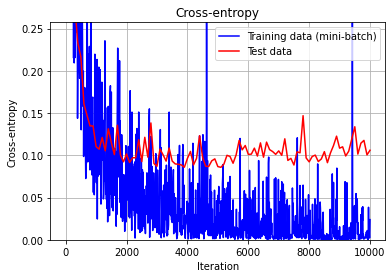

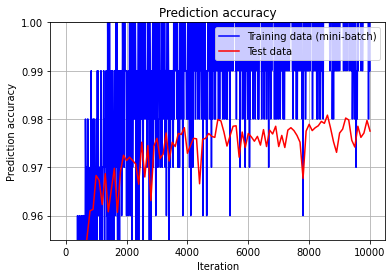

In [ ]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

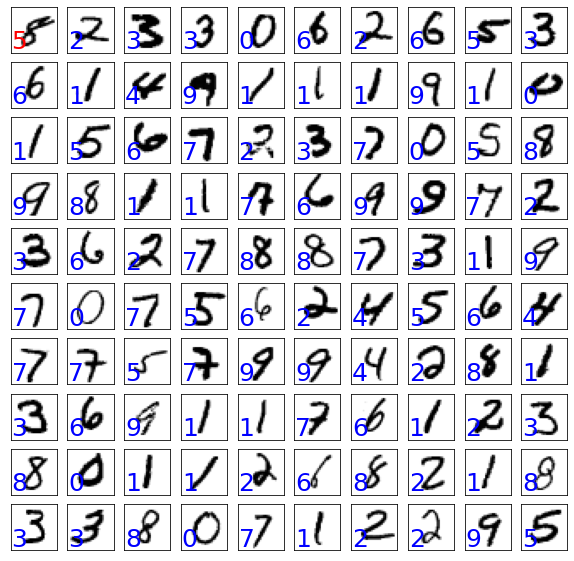

In [ ]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))
    
    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)
    
    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    
    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)
    
    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)
        
plt.show()